In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
import os
import types
import pickle as pkl
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from MulticoreTSNE import MulticoreTSNE as TSNE

import data_parser as dp
import config

In [3]:
def load_subjects_data(subjects):
    df_feats = []
    df_labels = []
    for sub in subjects:
        features_csv = Path(paths['features']) / feature / f'{sub}.csv'
        labels_csv = Path(paths['labels']) / emo_dim / f'{sub}.csv'
        
        df_feat = pd.read_csv(features_csv)
        df_label = pd.read_csv(labels_csv)
        
        df_feats.append(df_feat)
        df_labels.append(df_label)
        
    df_feats = pd.concat(df_feats)
    df_labels = pd.concat(df_labels)
    
    X = df_feats.iloc[:, 2:].values
    Y = df_labels.value.values
    sub_ids = df_feats.subject_id.values
        
    return X, Y, sub_ids

In [4]:
task = 'tl_stress'
feature = 'egemaps'
emo_dim = 'Delta_LNsAA'
normalize = True
normalize_labels = False
win_len = 200
hop_len = 100
n_folds = 5

In [6]:
paths = {'log': os.path.join(config.LOG_FOLDER, task),
         'data': os.path.join(config.DATA_FOLDER, task),
         'model': os.path.join(config.MODEL_FOLDER, task, 'log_file'),
         'features': config.PATH_TO_FEATURES[task],
         'labels': config.PATH_TO_LABELS[task],
         'partition': config.PARTITION_FILES[task],}

In [7]:
config.PARTITION_FILES[task]

'../data/tl_stress_2022/metadata/partition.csv'

In [8]:
cv_data = {}

FEAT_IDX = 0
LABEL_IDX = 1
SUB_IDX = 2

for cv_fold, (sub2part, part2sub) in enumerate(dp.get_data_partition_allfolds(paths['partition'], n_folds=n_folds), start=1):
    print(f'Loading Data CV Fold {cv_fold} ...')
    cv_data[cv_fold] = dict (
        # load subjects returns tuple of features, labels, metadatda (subject id)
        train = load_subjects_data(part2sub['train']),
        devel = load_subjects_data(part2sub['devel']),
        test = load_subjects_data(part2sub['test']),
    )
    print('Data loaded')

Loading Data CV Fold 1 ...
Data loaded
Loading Data CV Fold 2 ...
Data loaded
Loading Data CV Fold 3 ...
Data loaded
Loading Data CV Fold 4 ...
Data loaded
Loading Data CV Fold 5 ...
Data loaded


In [9]:
all_cvs = []
scaler = StandardScaler()
for split, data in cv_data.items():
    columns = [f'feat_{f}' for f in range(data['train'][0].shape[1])]
    
    scaler.fit(data['train'][0])
    
    df_train = pd.DataFrame(data=scaler.transform(data['train'][0]), columns=columns)
    df_train[emo_dim] = data['train'][1]
    df_train['subject'] = data['train'][2]
    df_train['cv_fold'] = split
    df_train['partition'] = 'train'
    
    df_devel = pd.DataFrame(data=scaler.transform(data['devel'][0]), columns=columns)
    df_devel[emo_dim] = data['devel'][1]
    df_devel['subject'] = data['devel'][2]
    df_devel['cv_fold'] = split
    df_devel['partition'] = 'devel'
    
    df_test = pd.DataFrame(data=scaler.transform(data['test'][0]), columns=columns)
    df_test[emo_dim] = data['test'][1]
    df_test['subject'] = data['test'][2]
    df_test['cv_fold'] = split
    df_test['partition'] = 'test'
    
    all_cvs.append(pd.concat([df_train, df_devel, df_test]))
    
df_all_cvs = pd.concat(all_cvs)

In [10]:
df_all_cvs.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,Delta_LNsAA,subject,cv_fold,partition
0,-1.013681,1.017892,-1.060510,-1.204314,-1.024711,-0.024478,-0.648267,-0.483777,-0.497542,-0.493422,...,0.318018,0.390360,-0.212267,-0.643616,-0.851264,0.528357,-0.08899,10,1,train
1,-1.007393,1.081229,-1.089891,-1.205605,-0.775903,0.698714,-0.642050,-0.495305,-0.470635,-0.486190,...,0.338203,0.409152,-0.171132,-0.680079,-0.837875,0.549994,-0.08899,10,1,train
2,-0.918679,1.061242,-1.060635,-1.112291,-0.651405,0.950687,-0.707388,-0.483036,-0.511983,-0.481845,...,0.318018,0.568879,-0.224443,-0.719579,-0.888213,0.676743,-0.08899,10,1,train
3,-1.078854,0.300729,-1.125849,-1.198367,-0.835852,0.632066,-0.666813,-0.428331,-0.479184,-0.296715,...,0.318018,0.550087,0.091842,-0.706557,-0.900617,0.519409,-0.08899,10,1,train
4,-1.097139,0.146306,-1.099692,-1.233611,-0.851430,0.525987,-0.901693,-0.882142,-0.603416,-0.537662,...,-0.001085,0.959740,-0.032750,-0.804224,-1.026766,0.522922,-0.08899,10,1,train


## Review Labels Per CV

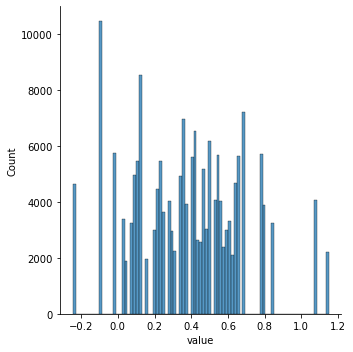

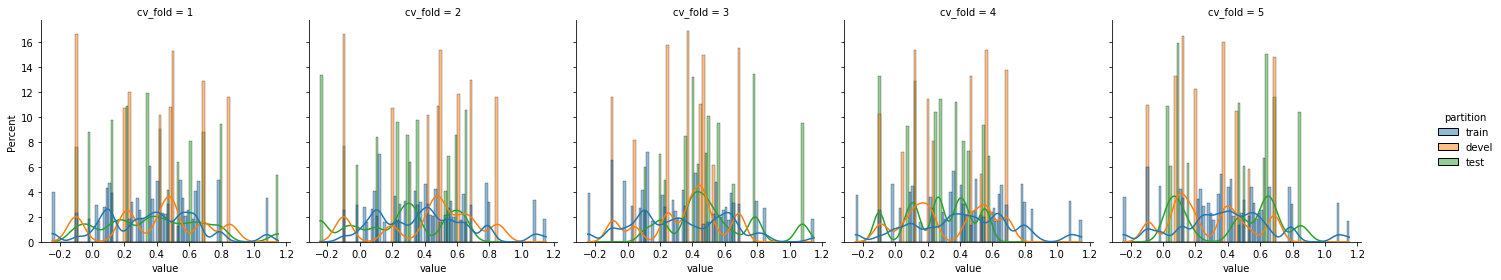

In [16]:
df_histplot_melt = df_all_cvs[[emo_dim, 'cv_fold', 'partition']].melt(id_vars=['cv_fold', 'partition'])


g = sns.displot(df_histplot_melt, x='value',
               )
plt.show()

g = sns.displot(
    df_histplot_melt, x="value", col="cv_fold", hue="partition",
    kind='hist', stat='percent', common_norm=False, kde=True,
    aspect=1, height=4, 
    facet_kws = {'margin_titles': True}
)

In [67]:
df_catplot_melt = df_all_cvs.drop([emo_dim, 'subject'], axis=1).melt(id_vars=['partition', 'cv_fold'])
df_catplot_melt.head()

,partition,cv_fold,variable,value
0,train,1,feat_0,-1.013681
1,train,1,feat_0,-1.007393
2,train,1,feat_0,-0.918679
3,train,1,feat_0,-1.078854
4,train,1,feat_0,-1.097139


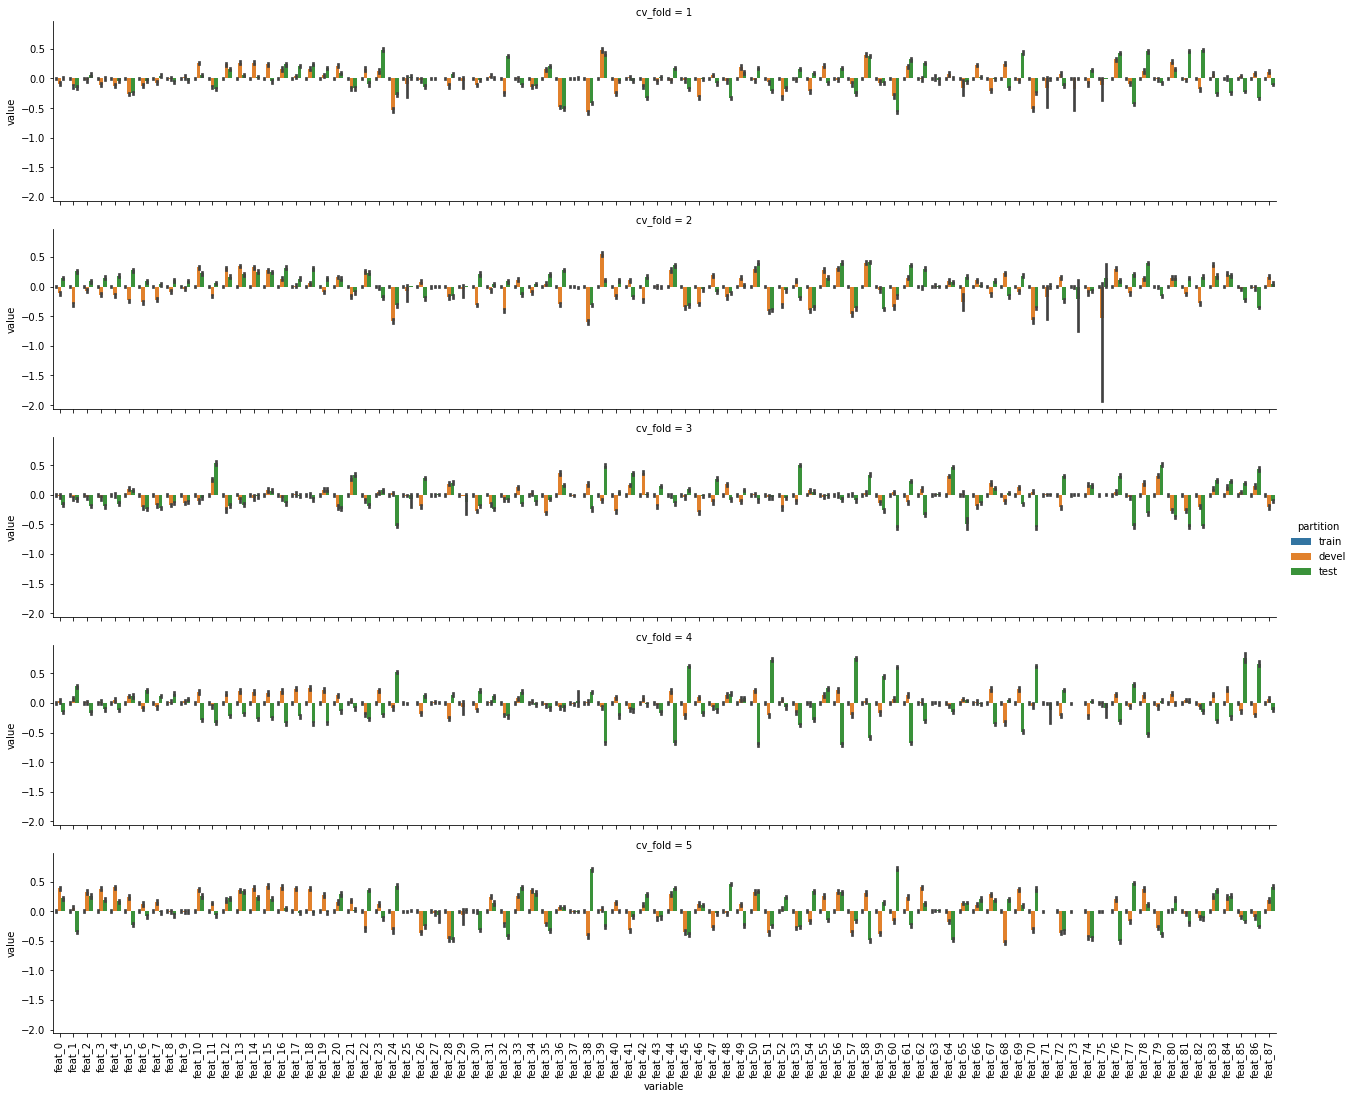

In [70]:
df_all_cvs_norm = df_all_cvs

df_catplot_melt = df_all_cvs.drop([emo_dim, 'subject'], axis=1).melt(id_vars=['partition', 'cv_fold'])
g = sns.catplot(
    data=df_catplot_melt, x='variable', y='value', hue='partition', row='cv_fold', kind='bar', 
    aspect=6, height=3, 
    facet_kws = {'margin_titles': True}
)
g.set_xticklabels(rotation=90);

## TSNE Plots

In [69]:
# Setup TSNE
tsne = TSNE(n_components=2,
            perplexity=50,
            learning_rate=10,
            n_iter=2500,
            n_jobs=4)

In [24]:
# get full data set
X_full = np.concatenate([cv_data[1]['train'][FEAT_IDX], cv_data[1]['devel'][FEAT_IDX], cv_data[1]['test'][FEAT_IDX]])
Y_full = np.concatenate([cv_data[1]['train'][LABEL_IDX], cv_data[1]['devel'][LABEL_IDX], cv_data[1]['test'][LABEL_IDX]])
subs_full = np.concatenate([cv_data[1]['train'][SUB_IDX], cv_data[1]['devel'][SUB_IDX], cv_data[1]['test'][SUB_IDX]])

X_full.shape, Y_full.shape, subs_full.shape

((36997, 88), (36997,), (36997,))

In [25]:
# run TSNE for Full Dataset
X_embed_full = tsne.fit_transform(X_full)

In [26]:
# Run TSNE For CV
embeddings = {}
for cv_fold, data in cv_data.items():
    
    X_train, Y_train, subs_train = data['train']
    dsid_train = np.ones_like(Y_train) * 0
    X_devel, Y_devel, subs_devel = data['devel']  
    dsid_devel = np.ones_like(Y_devel) * 1
    X_test, Y_test, subs_test = data['test']
    dsid_test = np.ones_like(Y_test) * 2
    
    X = np.concatenate([X_train, X_devel, X_test])
    Y = np.concatenate([Y_train, Y_devel, Y_test])
    subs = np.concatenate([subs_train, subs_devel, subs_test])
    dsids = np.concatenate([dsid_train, dsid_devel, dsid_test])

    X_embed = tsne.fit_transform(X)
    embeddings[cv_fold] = {
        'embedding': X_embed,
        'labels': Y,
        'dsids': dsids,
        'subjects': subs,
    }

/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/matplotlib/collections.py:980: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


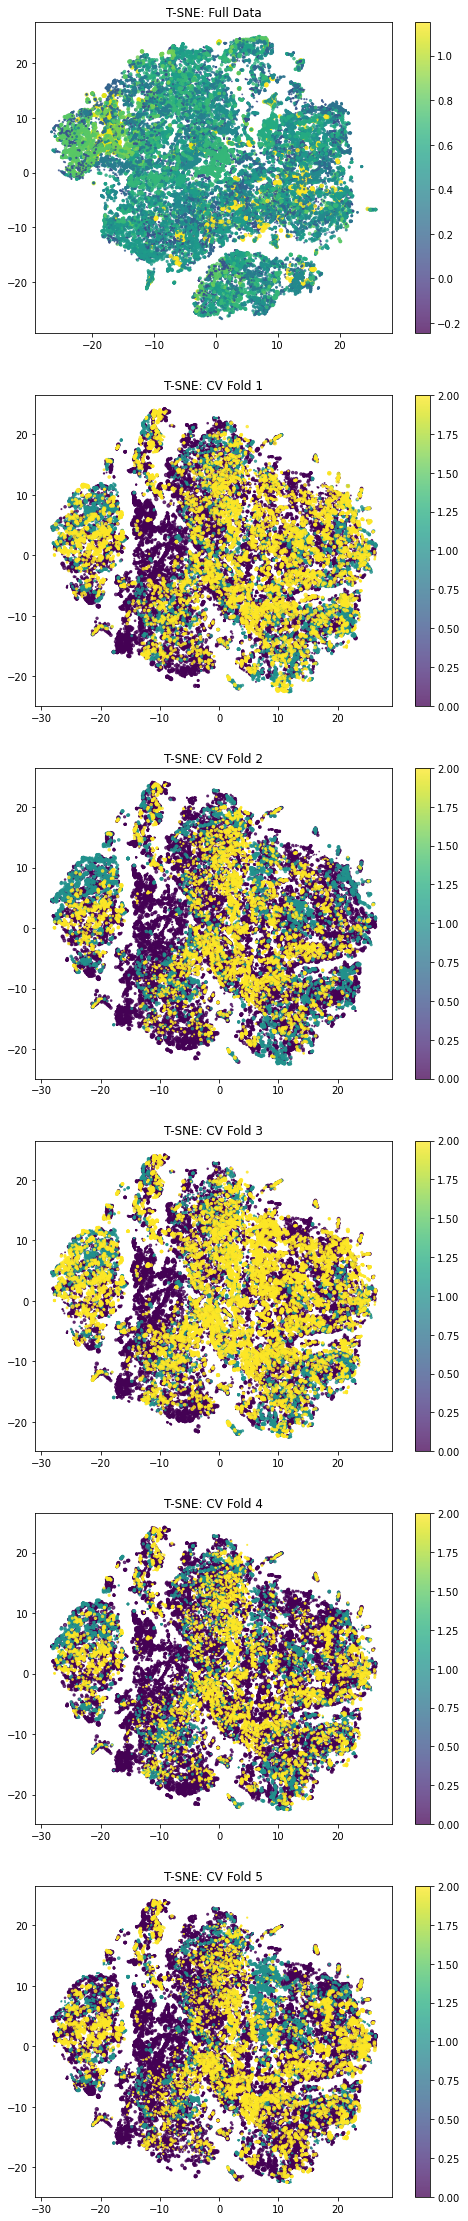

In [27]:
# plt T-SNE for Each CV
plt.figure(figsize=(8, 40))

plt.subplot(n_folds+1, 1, 1)
plt.scatter(x=X_embed_full[:, 0], y=X_embed_full[:, 1], c=Y_full, s=Y_full*10, alpha=0.75)
plt.title(f'T-SNE: Full Data')
plt.colorbar();

for cv_fold, embedding in embeddings.items():
    s = embedding['labels'] * 10
    c = embedding['dsids']
    plt.subplot(n_folds+1, 1, cv_fold+1)
    plt.scatter(x=X_embed[:, 0], y=X_embed[:, 1], s=s, c=c, alpha=0.75)
    plt.title(f'T-SNE: CV Fold {cv_fold}')
    plt.colorbar()

## Classical ML

In [28]:
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [43]:
# Pipeline
reg = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regress', None)
    ]
)

param_grid = [
    {
        "regress": [SGDRegressor()],
        "regress__penalty": ['l2', 'l1', 'elasticnet']
    },
    {
        "regress": [SVR()],
        "regress__kernel": ['rbf'],
        "regress__C": [0.1, 1, 10, 100],
        "regress__gamma": np.logspace(-2, 2, 3)
    },
    {
        "regress": [LinearSVR()],
        "regress__C": [0.1, 1, 10, 100],
    },
]

# param_grid = [
#     {
#         "regress": [SVR()],
#         "regress__kernel": ['rbf'],
#     },
# ]

In [72]:
sub_data = pd.read_csv('TSST_behavior.csv', delimiter=';', decimal=',', usecols=['Subject', 'Sex', 'Cond'])
sub_data['SexCond'] = sub_data['Sex'].astype(str) + sub_data['Cond'].astype(str)

class CVResults:
    pass

In [45]:
results = CVResults()
results.grids = {}
results.test_results = {}
results.test_labels = {}
results.test_preds = {}

for cv_fold, data in cv_data.items():
    
    print(f'Grid Search CV Fold {cv_fold}')
    X_train, Y_train, subs_train = data['train']
    X_devel, Y_devel, subs_devel = data['devel']  
    X_test, Y_test, subs_test = data['test']

    X = np.concatenate([X_train, X_devel], axis=0) 
    y = np.concatenate([Y_train, Y_devel])
    subs = np.concatenate([subs_train, subs_devel])
    strat_labels = np.squeeze([sub_data[sub_data.Subject == s]['SexCond'].values for s in subs])
    print(X.shape, y.shape, strat_labels.shape)
    
    print(f'Training Grid...')
    cv = StratifiedGroupKFold(n_splits=5)
    cv_splits = list(cv.split(X, strat_labels, subs))
    
    grid = GridSearchCV(reg, cv=cv_splits, n_jobs=3, param_grid=param_grid, scoring='neg_root_mean_squared_error', verbose=1)
    grid.fit(X, y)
    results.grids[cv_fold] = grid
    
    mean_scores = np.array(grid.cv_results_["mean_test_score"])
    results.test_results[cv_fold] = grid.score(X_test, Y_test)
    results.test_labels[cv_fold] = Y_test
    results.test_preds[cv_fold] = grid.predict(X_test)

    print(f'Done\nMean Scores: {mean_scores}')
    print(f'Test Data Results:', results.test_results[cv_fold])
    print()
    
print('Saving Results to gridsearch_results.pkl')
with open('gridsearch_results.pkl', 'wb') as f:
    pkl.dump(results, f)

Grid Search CV Fold 1
(28750, 88) (28750,) (28750,)
Training Grid...
Fitting 5 folds for each of 19 candidates, totalling 95 fits


/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converg

Done
Mean Scores: [-3.11710637e+03 -3.31257646e+03 -1.01278712e+03 -3.20728708e-01
 -2.86097948e-01 -2.86077827e-01 -3.29077306e-01 -2.85661671e-01
 -2.85692936e-01 -3.34144232e-01 -2.85661671e-01 -2.85692936e-01
 -3.34366406e-01 -2.85661671e-01 -2.85692936e-01 -3.79749540e-01
 -3.87763647e-01 -4.88497361e-01 -5.10763062e-01]
Test Data Results: -0.3208462519079956

Grid Search CV Fold 2
(30022, 88) (30022,) (30022,)
Training Grid...
Fitting 5 folds for each of 19 candidates, totalling 95 fits


/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converg

Done
Mean Scores: [-5.14461563e+03 -7.60946949e+03 -7.03264059e+03 -3.44851500e-01
 -2.87365484e-01 -2.87221206e-01 -3.52250960e-01 -2.85847090e-01
 -2.86024255e-01 -3.52400025e-01 -2.85847090e-01 -2.86024255e-01
 -3.52927690e-01 -2.85847090e-01 -2.86024255e-01 -3.89391552e-01
 -4.03263735e-01 -4.99557956e-01 -5.06351727e-01]
Test Data Results: -0.33099801656912187

Grid Search CV Fold 3
(28481, 88) (28481,) (28481,)
Training Grid...
Fitting 5 folds for each of 19 candidates, totalling 95 fits


/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converg

Done
Mean Scores: [-4.39405762e+03 -1.19460784e+03 -1.43661993e+03 -2.94686206e-01
 -3.05126095e-01 -3.05946237e-01 -3.05229677e-01 -2.96314037e-01
 -2.96253814e-01 -3.06787391e-01 -2.96314037e-01 -2.96253814e-01
 -3.06820291e-01 -2.96314037e-01 -2.96253814e-01 -3.43576715e-01
 -3.74857939e-01 -4.58780755e-01 -4.60653418e-01]
Test Data Results: -0.3630143931589563

Grid Search CV Fold 4
(29974, 88) (29974,) (29974,)
Training Grid...
Fitting 5 folds for each of 19 candidates, totalling 95 fits


/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converg

Done
Mean Scores: [-5.29149388e+03 -2.36575227e+03 -1.46817582e+03 -3.70523098e-01
 -3.13362766e-01 -3.13376182e-01 -3.82981881e-01 -3.11668749e-01
 -3.11586659e-01 -3.87747785e-01 -3.11668749e-01 -3.11586659e-01
 -3.87330820e-01 -3.11668749e-01 -3.11586659e-01 -4.08670083e-01
 -4.10341044e-01 -5.30061663e-01 -5.40974325e-01]
Test Data Results: -0.24523066022410522

Grid Search CV Fold 5
(30761, 88) (30761,) (30761,)
Training Grid...
Fitting 5 folds for each of 19 candidates, totalling 95 fits


/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/compute/homes/djohnson/miniconda3/envs/torch10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converg

Done
Mean Scores: [-7.62201757e+04 -1.46900463e+04 -1.45620113e+04 -3.53183884e-01
 -2.80071657e-01 -2.80166920e-01 -3.63531426e-01 -2.79302563e-01
 -2.79214051e-01 -3.68153277e-01 -2.79302563e-01 -2.79214051e-01
 -3.68276666e-01 -2.79302563e-01 -2.79214051e-01 -3.83903145e-01
 -3.89186252e-01 -5.69515544e-01 -5.64357521e-01]
Test Data Results: -0.29448213725790184

Saving Results to gridsearch_results.pkl


In [73]:
with open('gridsearch_results.pkl', 'rb') as f:
    results_pkl = pkl.load(f)

In [79]:
for (cv_fold, g), (cv_fold, test_score) in zip(results_pkl.grids.items(), results_pkl.test_results.items()):
    print(f'CV {cv_fold}: {g.best_params_}: {-test_score:0.4f}')

CV 1: {'regress': SVR(C=1, gamma=100.0), 'regress__C': 1, 'regress__gamma': 1.0, 'regress__kernel': 'rbf'}: 0.3208
CV 2: {'regress': SVR(C=1, gamma=100.0), 'regress__C': 1, 'regress__gamma': 1.0, 'regress__kernel': 'rbf'}: 0.3310
CV 3: {'regress': SVR(C=1, gamma=100.0), 'regress__C': 0.1, 'regress__gamma': 0.01, 'regress__kernel': 'rbf'}: 0.3630
CV 4: {'regress': SVR(C=1, gamma=100.0), 'regress__C': 1, 'regress__gamma': 100.0, 'regress__kernel': 'rbf'}: 0.2452
CV 5: {'regress': SVR(C=1, gamma=100.0), 'regress__C': 1, 'regress__gamma': 100.0, 'regress__kernel': 'rbf'}: 0.2945


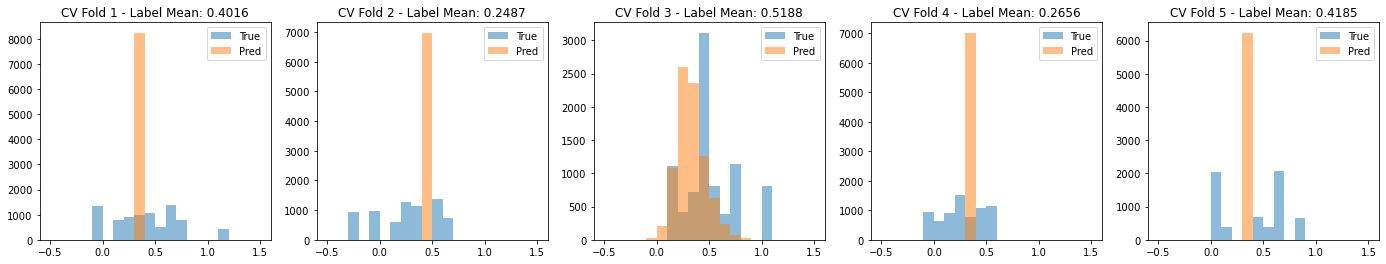

In [55]:
plt.figure(figsize=(24, 4))
for (cv_fold, y_true), (_, y_pred) in zip(results_pkl.test_labels.items(), results_pkl.test_preds.items()):
    plt.subplot(1, 5, cv_fold)
    plt.hist(y_true, label='True', alpha=.5, range=[-0.5, 1.5], bins=20)
    plt.hist(y_pred, label='Pred', alpha=.5, range=[-0.5, 1.5], bins=20)
    plt.legend()
    plt.title(f'CV Fold {cv_fold} - Label Mean: {y_true.mean():0.4f}')

In [75]:
g.best_score_

-0.27921405078425765